In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [2]:
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True)
dataset = dataset['train']
class_names = ['cat', 'dog']

size = tf.data.experimental.cardinality(dataset).numpy()
print(f'number of images:{size}')

number of images:23262


We need all images to be the same size, we can use [`resize`](https://www.tensorflow.org/api_docs/python/tf/image/resize):

```python
tf.image.resize(
    images, size, method=ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
```


In [3]:
image_size = (96, 96, 3)


def preprocess_img(images, size=(96, 96)):
    return tf.image.resize(images, size)


dataset = dataset.map(lambda images, labels: (preprocess_img(images), labels))

Split the dataset, you can use [different techniques](https://www.tensorflow.org/datasets/splits)

In [4]:
batch_size = 32
train_size = int(0.75 * size)
val_size = int(0.1 * size)

train_ds = dataset.take(train_size)
train_ds = train_ds.shuffle(1000).batch(batch_size).cache()
remaining = dataset.skip(train_size)

val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

val_ds = val_ds.shuffle(1000).batch(batch_size).cache()
test_ds = test_ds.batch(batch_size).cache()

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

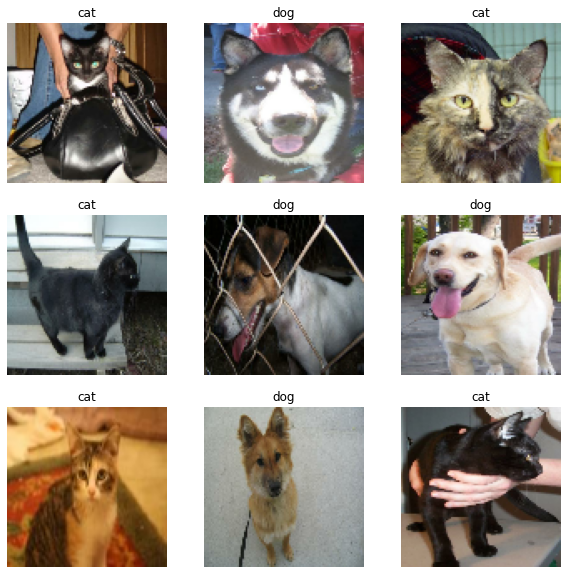

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Question 1: Create a model with two convolutional layers without pooling and without any regularization

In [7]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_1')(reescaling)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_2')(conv_1)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(conv_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [8]:
model_1.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [9]:
epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,  
    verbose=1)

history = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/8
546/546 [==============================] - 49s 85ms/step - loss: 0.7182 - accuracy: 0.6083 - val_loss: 0.5541 - val_accuracy: 0.7266
Epoch 2/8
546/546 [==============================] - 13s 25ms/step - loss: 0.4954 - accuracy: 0.7596 - val_loss: 0.5539 - val_accuracy: 0.7442
Epoch 3/8
546/546 [==============================] - 13s 24ms/step - loss: 0.3325 - accuracy: 0.8568 - val_loss: 0.6428 - val_accuracy: 0.7334
Epoch 4/8
546/546 [==============================] - 13s 24ms/step - loss: 0.1763 - accuracy: 0.9317 - val_loss: 0.8668 - val_accuracy: 0.7098
Epoch 5/8
546/546 [==============================] - 13s 24ms/step - loss: 0.1146 - accuracy: 0.9609 - val_loss: 0.9782 - val_accuracy: 0.7124
Epoch 6/8
546/546 [==============================] - 13s 24ms/step - loss: 0.0814 - accuracy: 0.9734 - val_loss: 1.1292 - val_accuracy: 0.7141
Epoch 7/8
546/546 [==============================] - 13s 25ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 1.4740 - val_accuracy: 0.6943

In [10]:
results = model_1.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 23s 39ms/step - loss: 1.4758 - accuracy: 0.6951
Test Loss: 1.475791335105896
Test Accuracy: 0.6951289176940918


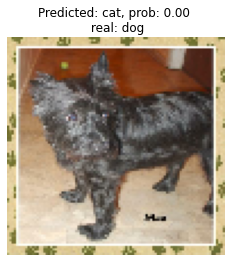

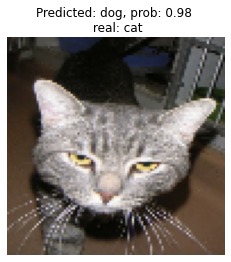

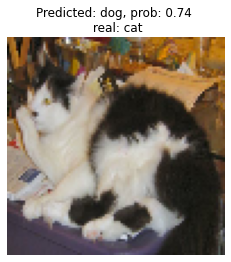

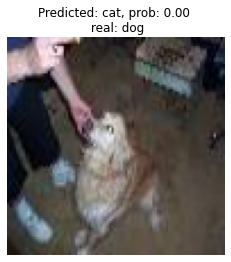

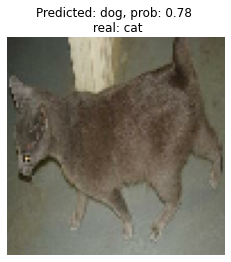

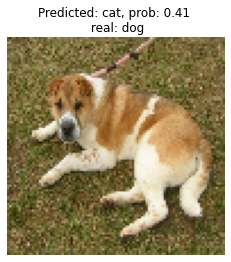

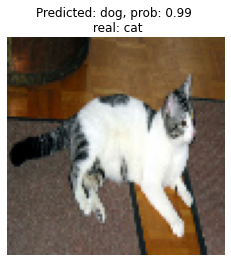

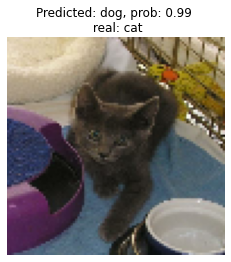

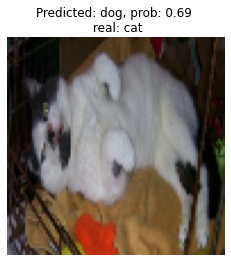

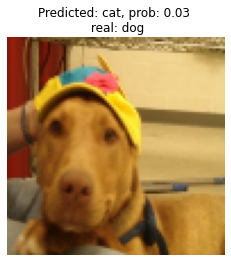

In [11]:
def show_errors(val_ds, model, class_names, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_prob = model.predict(images)
        preds = (1.0 * (pred_prob >= 0.5)).astype(np.int32).flatten()
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]
            prob = pred_prob[ind][0]
            plt.imshow(images[ind].numpy().astype("uint8"))
            plt.title(
                'Predicted: {0}, prob: {1:.2f} \n real: {2}'
                .format(pred_class, prob, real_class))
            plt.axis('off')
            plt.show()

            if n_plots == n_images:
                return
    return

show_errors(test_ds, model_1, class_names, n_images=10)

## Question 2: Introduce pooling to the previous model and obtain a better `test_accuracy`, Do not use any regularization

In [12]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_1')(reescaling)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(16, 3, padding='valid', activation='relu',
                       name='conv_2')(pool_1)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_2)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_2 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [13]:
model_2.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,  
    verbose=1)

history = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/8
546/546 [==============================] - 7s 11ms/step - loss: 0.6706 - accuracy: 0.5869 - val_loss: 0.5794 - val_accuracy: 0.6870
Epoch 2/8
546/546 [==============================] - 6s 11ms/step - loss: 0.5299 - accuracy: 0.7365 - val_loss: 0.5228 - val_accuracy: 0.7304
Epoch 3/8
546/546 [==============================] - 6s 11ms/step - loss: 0.4659 - accuracy: 0.7800 - val_loss: 0.4917 - val_accuracy: 0.7485
Epoch 4/8
546/546 [==============================] - 6s 11ms/step - loss: 0.4156 - accuracy: 0.8092 - val_loss: 0.4812 - val_accuracy: 0.7678
Epoch 5/8
546/546 [==============================] - 6s 11ms/step - loss: 0.3646 - accuracy: 0.8394 - val_loss: 0.5056 - val_accuracy: 0.7657
Epoch 6/8
546/546 [==============================] - 6s 11ms/step - loss: 0.3170 - accuracy: 0.8619 - val_loss: 0.5458 - val_accuracy: 0.7592
Epoch 7/8
546/546 [==============================] - 6s 11ms/step - loss: 0.2674 - accuracy: 0.8907 - val_loss: 0.5676 - val_accuracy: 0.7580
Epoch 

In [14]:
results = model_2.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 1s 6ms/step - loss: 0.6456 - accuracy: 0.7607
Test Loss: 0.6456436514854431
Test Accuracy: 0.7607449889183044


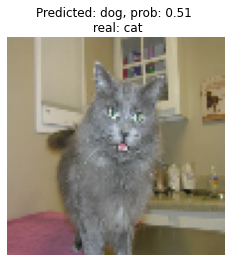

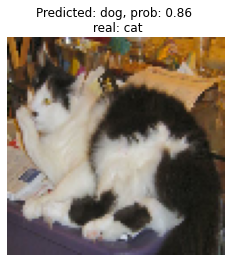

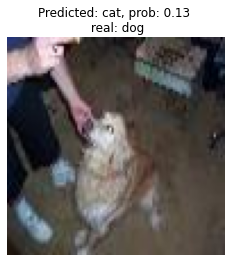

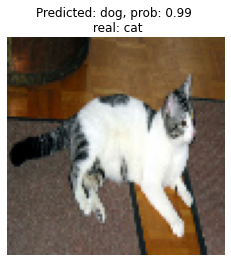

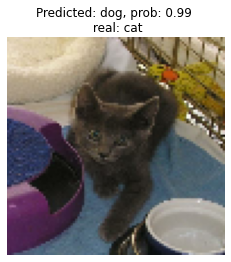

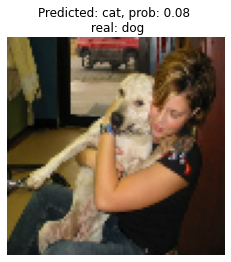

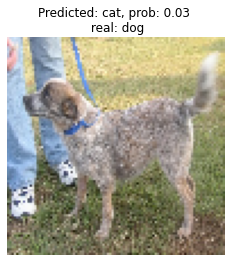

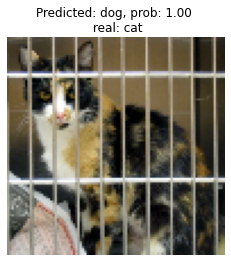

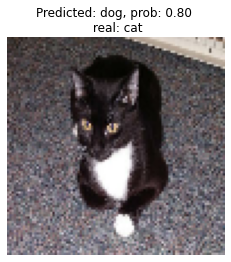

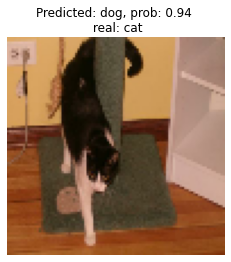

In [15]:
show_errors(test_ds, model_2, class_names, n_images=10)

## Question 3: Introduce regularization (you can try data augmentation) and increase the number of layers to obtain a better `test_accuracy`. Try to obtain `Test Accuracy > 0.8`



In [17]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.25),
  ]
)

In [18]:
inputs = tf.keras.Input(shape=image_size, name='input')
reescaling = layers.experimental.preprocessing.Rescaling(1. / 255)(inputs)

# Conv Layer 1
conv_1 = layers.Conv2D(32, 3, padding='valid', name='conv_1')(reescaling)
conv_1 = layers.BatchNormalization()(conv_1)
conv_1 = layers.Activation('relu')(conv_1)
pool_1 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_1')(conv_1)

# Conv Layer 2
conv_2 = layers.Conv2D(32, 3, padding='valid', name='conv_2')(pool_1)
conv_2 = layers.BatchNormalization()(conv_2)
conv_2 = layers.Activation('relu')(conv_2)
pool_2 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_2')(conv_2)

# Conv Layer 3
conv_3 = layers.Conv2D(32, 3, padding='valid', name='conv_3')(pool_2)
conv_3 = layers.BatchNormalization()(conv_3)
conv_3 = layers.Activation('relu')(conv_3)
pool_3 = layers.MaxPooling2D(pool_size=(2, 2), name='pool_3')(conv_3)


# Fully-connected
# Flattening
flat = layers.Flatten(name='flatten')(pool_3)
flat = layers.Dropout(0.3)(flat)
dense = layers.Dense(64, activation='relu', name='dense')(flat)
outputs = layers.Dense(1, activation='sigmoid', name='output')(dense)

model_3 = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [19]:
model_3.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 8

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=2,  
    verbose=1)

history = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/8
546/546 [==============================] - 13s 22ms/step - loss: 0.6538 - accuracy: 0.6411 - val_loss: 0.5554 - val_accuracy: 0.7120
Epoch 2/8
546/546 [==============================] - 12s 21ms/step - loss: 0.5043 - accuracy: 0.7468 - val_loss: 0.4578 - val_accuracy: 0.7880
Epoch 3/8
546/546 [==============================] - 12s 21ms/step - loss: 0.4353 - accuracy: 0.7942 - val_loss: 0.4333 - val_accuracy: 0.8070
Epoch 4/8
546/546 [==============================] - 12s 21ms/step - loss: 0.3935 - accuracy: 0.8162 - val_loss: 0.4388 - val_accuracy: 0.7906
Epoch 5/8
546/546 [==============================] - 12s 21ms/step - loss: 0.3589 - accuracy: 0.8411 - val_loss: 0.3620 - val_accuracy: 0.8448
Epoch 6/8
546/546 [==============================] - 12s 21ms/step - loss: 0.3330 - accuracy: 0.8560 - val_loss: 0.3780 - val_accuracy: 0.8465
Epoch 7/8
546/546 [==============================] - 12s 21ms/step - loss: 0.3121 - accuracy: 0.8618 - val_loss: 0.3603 - val_accuracy: 0.8426

In [20]:
results = model_3.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 1s 9ms/step - loss: 0.3936 - accuracy: 0.8307
Test Loss: 0.39360862970352173
Test Accuracy: 0.830659031867981


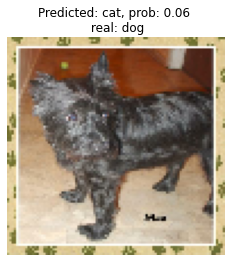

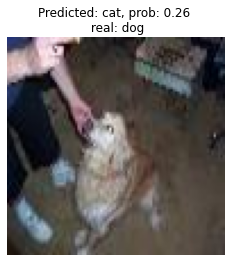

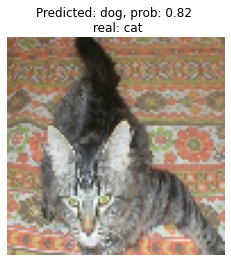

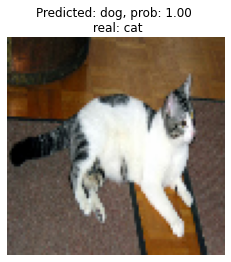

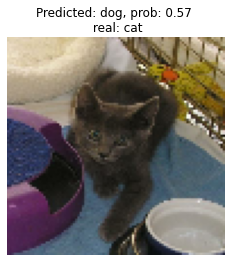

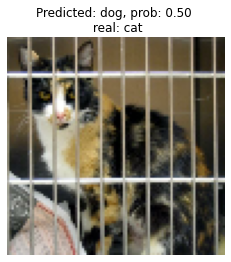

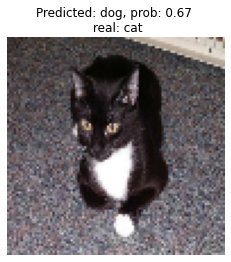

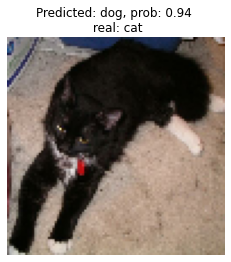

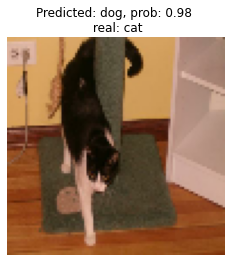

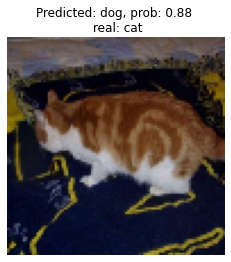

In [21]:
show_errors(test_ds, model_3, class_names, n_images=10)

## Question 4: Try transfer learning

In [22]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=image_size, include_top=False)
pretrained_model.trainable = False


9412608/9406464 [==============================] - 0s 0us/step


In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [24]:
inputs = tf.keras.Input(shape=image_size, name='input')

# pre-trained model
x = preprocess_input(inputs)
x = pretrained_model(x)

# classifier
flat = tf.keras.layers.Flatten()(x)
flat = tf.keras.layers.Dropout(0.5)(flat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flat)

model_tl = tf.keras.Model(inputs, outputs)
model_tl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 96, 96, 3)]       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 96, 96, 3)         0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 96, 96, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11521 

In [25]:
model_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

epochs = 2

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=2,  
    verbose=1)

history = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/2
546/546 [==============================] - 19s 28ms/step - loss: 0.2083 - accuracy: 0.9326 - val_loss: 0.1583 - val_accuracy: 0.9609
Epoch 2/2
546/546 [==============================] - 14s 26ms/step - loss: 0.1502 - accuracy: 0.9620 - val_loss: 0.1736 - val_accuracy: 0.9622


In [26]:
results = model_tl.evaluate(test_ds, verbose=1)
print('Test Loss: {}'.format(results[0]))
print('Test Accuracy: {}'.format(results[1]))

110/110 [==============================] - 3s 24ms/step - loss: 0.1683 - accuracy: 0.9573
Test Loss: 0.16829748451709747
Test Accuracy: 0.9573065638542175


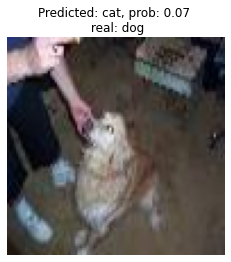

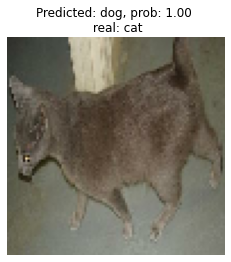

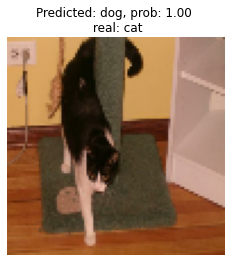

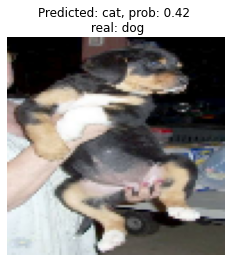

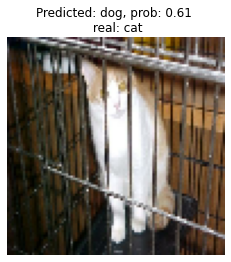

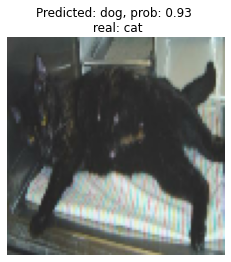

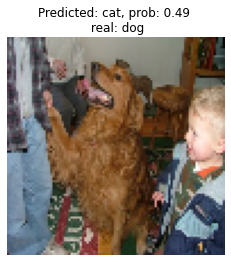

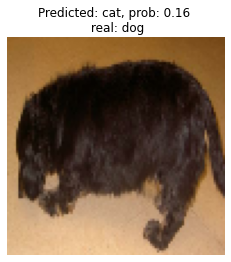

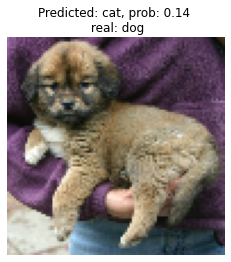

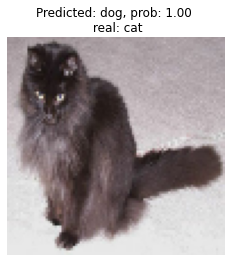

In [27]:
show_errors(test_ds, model_tl, class_names, n_images=10)

# Generalization

In [28]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image

def predict_plot(image_path, model, class_names, image_size):
    image = read_image(image_path, image_size[:2])
    prob = model.predict(np.expand_dims(image, 0))[0][0]
    pred_class = class_names[(1.0 * (prob >= 0.5)).astype(np.int32)]
    plt.imshow(image)
    plt.title(
        'Predicted: {0}, prob: {1:.2f}'
        .format(pred_class, prob))
    plt.axis('off')
    plt.show()

model 1


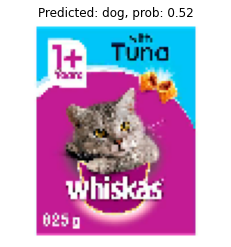

model 2


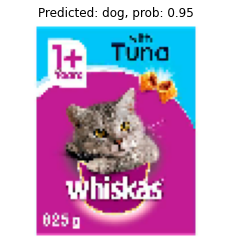

model 3


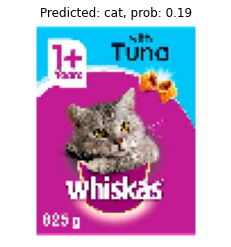

model tl


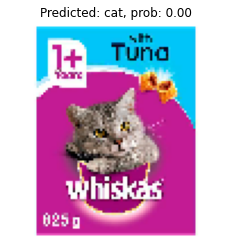

In [29]:
url = 'https://assets.sainsburys-groceries.co.uk/gol/6754229/1/640x640.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_1.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

model 1


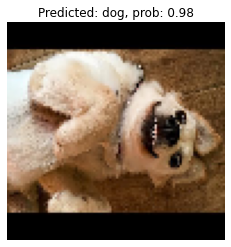

model 2


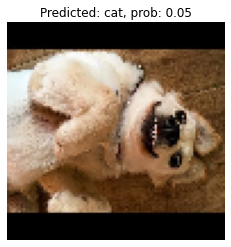

model 3


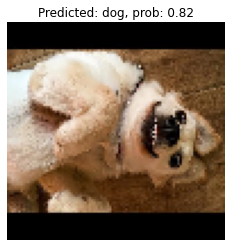

model tl


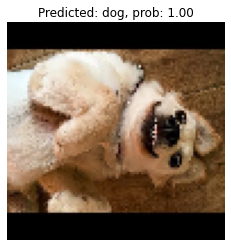

In [30]:
url = 'https://i.ytimg.com/vi/3dcli9i_pvA/hqdefault.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_2.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)

model 1


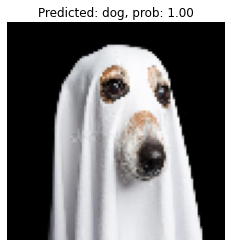

model 2


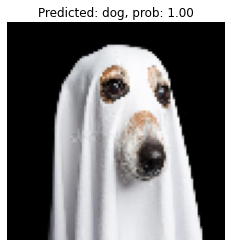

model 3


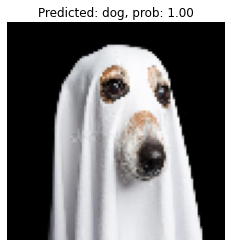

model tl


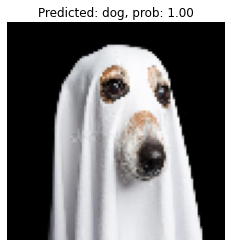

In [31]:
url = 'https://thumbs.dreamstime.com/b/halloween-ghost-portrait-funny-dog-black-background-adorable-pup-muzle-153863580.jpg'
image_path = tf.keras.utils.get_file("dog_vs_cat_3.jpg", url)
print('model 1')
predict_plot(image_path, model_1, class_names, image_size)
print('model 2')
predict_plot(image_path, model_2, class_names, image_size)
print('model 3')
predict_plot(image_path, model_3, class_names, image_size)
print('model tl')
predict_plot(image_path, model_tl, class_names, image_size)